# Data Exploration

**Objective**: Understand the structure, quality, and characteristics of the historical oil on PADD 3 (R30) (Gulf Coast), which includes Texas and Louisiana – the largest oil-producing region in the U.S. This dataset was obtained from an oficcial US Company, calkled EIA. 

*NOTE:*
* MBBL/D → Thousand Barrels Per Day (average daily production in that month)
* MBBL → Total Thousand Barrels produced in the entire month

https://www.eia.gov/opendata/browser/petroleum/crd/crpdn?frequency=monthly&data=value;&start=1960-01&sortColumn=period;&sortDirection=desc;

### 1. Imports & Setup

In [40]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('muted')

In [65]:
# Load API key from .env file
load_dotenv()
API_KEY = os.getenv('EIA_API_KEY')

### 2.Data Loading

In [69]:
# Configure API request for PADD 3 (R30)
base_url = (
    'https://api.eia.gov/v2/petroleum/crd/crpdn/data/'
    '?api_key={}'
    '&frequency=monthly'
    '&data[0]=value'
    '&facets[duoarea][]=R30'
    '&start=1960-01'
    '&sort[0][column]=period'
    '&sort[0][direction]=asc'
    '&offset={}'
    '&length=5000'
)

all_records = []
offset = 0

while True:
    url = base_url.format(API_KEY, offset)
    response = requests.get(url)
    
    if response.status_code != 200:
        print(f"Error at offset {offset}: {response.status_code}")
        break
        
    data = response.json()
    records = data['response']['data']
    all_records.extend(records)
    
    if len(records) < 5000:
        break  # Exit loop when all data is retrieved
    
    offset += 5000

# Process and save data
if all_records:
    df = pd.DataFrame(all_records)
    df['period'] = pd.to_datetime(df['period'])
    df.to_csv('../data/raw/oil_production_padd3_1960_present.csv', index=False)
    print(f"Success! Saved {len(df)} records.")
else:
    print("No data found. Check your API key or parameters.")

Success! Saved 1060 records.


In [84]:
# Preview the dataframe
df.head()

,period,duoarea,area-name,product,product-name,process,process-name,series,series-description,value,units
0,1981-01-01,R30,PADD 3,EPC0,Crude Oil,FPF,Field Production,MCRFPP32,Gulf Coast (PADD 3) Field Production of Crude ...,4277,MBBL/D
1,1981-01-01,R30,PADD 3,EPC0,Crude Oil,FPF,Field Production,MCRFPP31,Gulf Coast (PADD 3) Field Production of Crude ...,132577,MBBL
2,1981-02-01,R30,PADD 3,EPC0,Crude Oil,FPF,Field Production,MCRFPP32,Gulf Coast (PADD 3) Field Production of Crude ...,4265,MBBL/D
3,1981-02-01,R30,PADD 3,EPC0,Crude Oil,FPF,Field Production,MCRFPP31,Gulf Coast (PADD 3) Field Production of Crude ...,119414,MBBL
4,1981-03-01,R30,PADD 3,EPC0,Crude Oil,FPF,Field Production,MCRFPP32,Gulf Coast (PADD 3) Field Production of Crude ...,4287,MBBL/D


### 3.Basic Data Overview

In [85]:
# transform value to numeric type.
df['value'] = pd.to_numeric(df['value'], errors='coerce')

In [86]:
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
df.info()
df.describe().T

Rows: 1060, Columns: 11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1060 entries, 0 to 1059
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   period              1060 non-null   datetime64[ns]
 1   duoarea             1060 non-null   object        
 2   area-name           1060 non-null   object        
 3   product             1060 non-null   object        
 4   product-name        1060 non-null   object        
 5   process             1060 non-null   object        
 6   process-name        1060 non-null   object        
 7   series              1060 non-null   object        
 8   series-description  1060 non-null   object        
 9   value               1060 non-null   int64         
 10  units               1060 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 91.2+ KB


,count,mean,min,25%,50%,75%,max,std
period,1060,2003-01-15 15:37:21.509433984,1981-01-01 00:00:00,1992-01-01 00:00:00,2003-01-16 12:00:00,2014-02-01 00:00:00,2025-02-01 00:00:00,NaN
value,1060.0,69601.087736,1664.0,3442.75,29887.5,105587.75,305104.0,77320.766132


### 4.Data Quality Checks

In [87]:
# Check for missing values
missing = df.isnull().sum()
print("Missing values:\n", missing[missing > 0])

Missing values:
 Series([], dtype: int64)


In [88]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Duplicated rows: {duplicates}")

Duplicated rows: 0


### 5.Data Preprocessing

In [99]:
# Sort by period.
df['period'] = pd.to_datetime(df['period'])
df = df.sort_values(by='period').reset_index(drop=True)

# Filter for main product (Crude Oil + Field Production)
df_main = df[(df['product-name'] == 'Crude Oil') & 
             (df['process-name'] == 'Field Production')]

# Create a pivot table
pivot_df = df_main.pivot_table(index='period', 
                               columns='units', 
                               values='value', 
                               aggfunc='sum')
pivot_df.head(25)

units,MBBL,MBBL/D
period,,
1981-01-01,132577,4277
1981-02-01,119414,4265
1981-03-01,132899,4287
1981-04-01,127524,4251
1981-05-01,129558,4179
1981-06-01,126566,4219
1981-07-01,129775,4186
1981-08-01,130475,4209
1981-09-01,125898,4197


### 6.Visualization

#### 6.1 Production over time

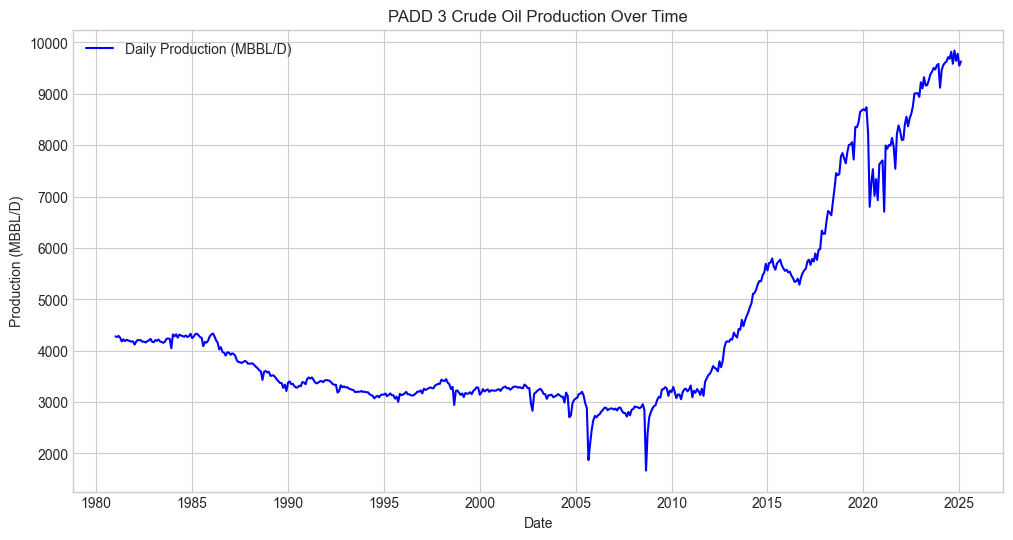

In [100]:
plt.figure(figsize=(12,6))
plt.plot(pivot_df.index, pivot_df['MBBL/D'], label='Daily Production (MBBL/D)', color='blue')
plt.title("PADD 3 Crude Oil Production Over Time")
plt.xlabel("Date")
plt.ylabel("Production (MBBL/D)")
plt.legend()
plt.show()

#### 6.2 Rolling average to observe trends

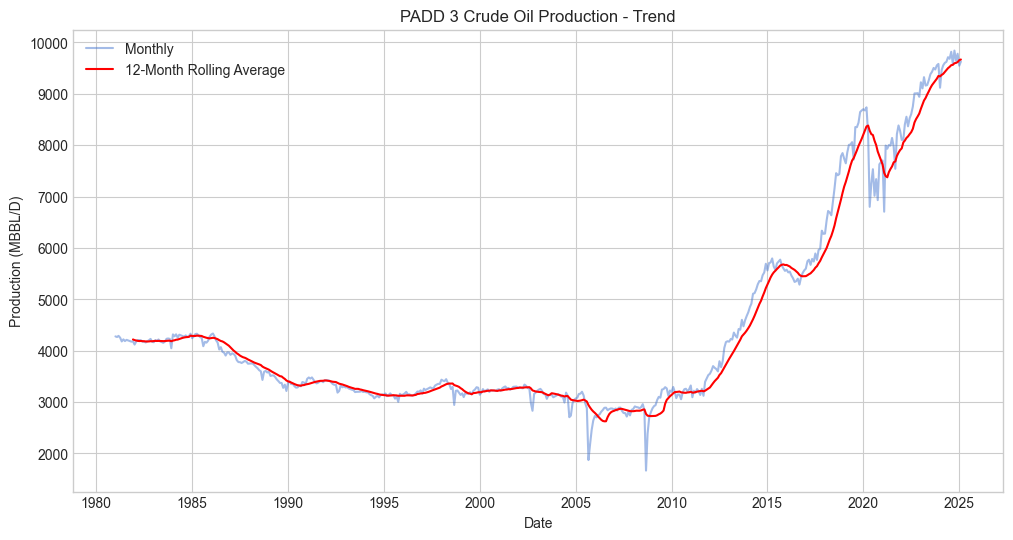

In [101]:
pivot_df['rolling_12m'] = pivot_df['MBBL/D'].rolling(12).mean()
plt.figure(figsize=(12,6))
plt.plot(pivot_df.index, pivot_df['MBBL/D'], alpha=0.5, label='Monthly')
plt.plot(pivot_df.index, pivot_df['rolling_12m'], color='red', label='12-Month Rolling Average')
plt.title("PADD 3 Crude Oil Production - Trend")
plt.xlabel("Date")
plt.ylabel("Production (MBBL/D)")
plt.legend()
plt.show()

#### 6.3 Seasonal plot

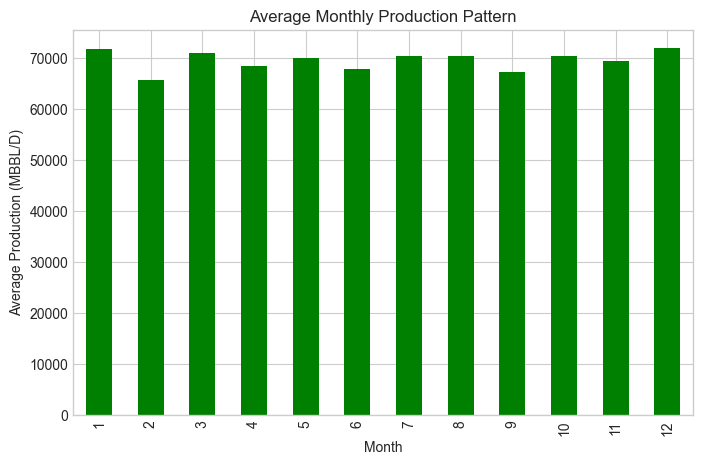

In [102]:
df_main['year'] = df_main['period'].dt.year
df_main['month'] = df_main['period'].dt.month
monthly_avg = df_main.groupby('month')['value'].mean()

plt.figure(figsize=(8,5))
monthly_avg.plot(kind='bar', color='green')
plt.title("Average Monthly Production Pattern")
plt.xlabel("Month")
plt.ylabel("Average Production (MBBL/D)")
plt.show()


We observe a clear increasing trend from the 1980s to the early 2010s, peaking in 2019, followed by volatility around the COVID-19 pandemic. Strong seasonality is not evident, suggesting production is more driven by macroeconomic and policy factors.

In [ ]:
pivot_df.reset_index().to_csv("../data/cleaned/oil_production_cleaned.csv", index=False)